In [2]:
#Kolminkertainen eksponentiaalinen tasoitus
#Kolminkertaista eksponentiaalista tasoitusta kutsutaan myös Holt-Winterin malliksi. Eksponentiaalisen tasoituksen mallit (yksinkertainen, kaksinkertainen ja kolminkertainen) ovat erityisen suosittuja liiketaloudessa kysynnän ennustamisessa. Mallit ovat helppokäyttöisiä, nopeasti laskettavissa ja helposti päivitettävissä uusien havaintojen myötä.
#Holt-Winterin malli huomioi sekä trendin että kausivaihtelun.
#Eksponentiaalinen tasoitus löytyy statsmodels.tsa-kirjastosta.
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.api import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [3]:
df=pd.read_excel('http://taanila.fi/CO2.xlsx')
df.index = pd.to_datetime(df['Kuukausi'],format="%Y-%m")
df=df.drop('Kuukausi',axis=1)
df.head()

,CO2
Kuukausi,
1999-12-01,368.04
2000-01-01,369.25
2000-02-01,369.50
2000-03-01,370.56
2000-04-01,371.82


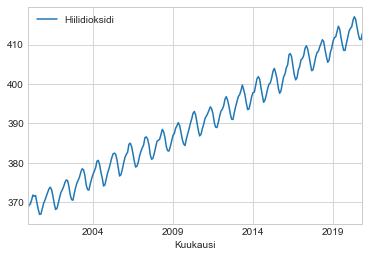

In [4]:
df = df.rename(columns = {'CO2': 'Hiilidioksidi'})
df.plot()

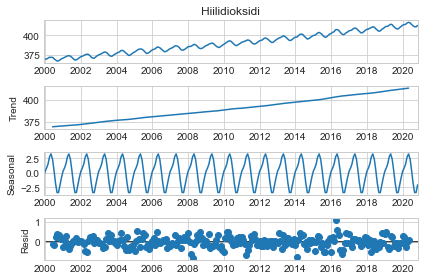

In [5]:
# Aikasarjan vaihtelua aiheuttavien komponenttien erottelu
# Observed=alkuperäinen aikasarja, Trend=trendi, Seasonal=kausivaihtelu,
# Residual=muu kuin trendiin ja kausivaihteluun liittyvä vaihtelu
# Alimmassa aikasarjassa on selvästi havaittavat trendi ja kausivaihtelu. Koska kyse on vuorokausidatasta, niin kausivaihtelu esiintyy neljän havainnon (40 päivän) jaksoissa.
decompose = seasonal_decompose(df['Hiilidioksidi']).plot()

In [6]:
#Mallin sovitus
#Ennustemalli sovitetaan (fit()) dataan. Tuloksena saadaan olio (tässä olen antanut oliolle nimeksi malli), joka sisältää monenlaista tietoa mallista.
#Trendiin (trend) käytän summamallia (add), jossa trendi on aikasarjaan lisättävä termi. Tämä on suositeltavin vaihtoehto.
#Kausivaihteluun (seasonal) käytän summamallia (add) tai tulomallia (mul). Tulomallissa kausivaihtelu ilmenee kertoimina. Tässä olen kokeillut myös summamallia, mutta tulomalli osoittautui paremmaksi.
#seasonal_periods-parametrille käytän arvoa 4, koska kausivaihtelu esiintyy neljän vuosineljänneksen jaksoissa.
#freq-parametrille käytän arvoa 'MS', koska kyseessä ovat kuukauden ensimmäiset päivät. Lisätietoa freq-parametrin mahdollisista arvoista https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
malli = ExponentialSmoothing(df['Hiilidioksidi'], trend = 'add', seasonal = 'mul', 
                             seasonal_periods = 4, freq='MS').fit()

In [7]:
# malli-olion avulla saan mallin mukaan simuloidut ennusteet (fittedvalues) jo toteutuneille ajankohdille
df['Ennuste'] = malli.fittedvalues
df

,Hiilidioksidi,Ennuste
Kuukausi,,
1999-12-01,368.04,369.460535
2000-01-01,369.25,367.981062
2000-02-01,369.50,368.924935
2000-03-01,370.56,371.179813
2000-04-01,371.82,369.902802
...,...,...
2020-07-01,414.38,416.063089
2020-08-01,412.55,413.409623
2020-09-01,411.29,410.783125


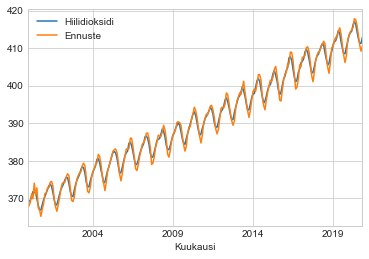

In [8]:
# Alkuperäinen aikasarja ja mallin mukaiset ennusteet samaan kaavioon
df.plot()

In [9]:
# Ennustevirheet (residuaalit) löytyvät malli-oliosta
df['Ennustevirhe'] = malli.resid
df

,Hiilidioksidi,Ennuste,Ennustevirhe
Kuukausi,,,
1999-12-01,368.04,369.460535,-1.420535
2000-01-01,369.25,367.981062,1.268938
2000-02-01,369.50,368.924935,0.575065
2000-03-01,370.56,371.179813,-0.619813
2000-04-01,371.82,369.902802,1.917198
...,...,...,...
2020-07-01,414.38,416.063089,-1.683089
2020-08-01,412.55,413.409623,-0.859623
2020-09-01,411.29,410.783125,0.506875


Text(0, 0.5, 'Ennustevirhe')

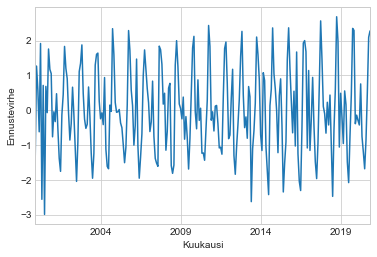

In [10]:
#Mallin tarkastelu
#Mallin hyvyyden tarkasteluun on monia tapoja. Tässä käytän
#ennustevirheiden aikasarjaa viivakaaviona
#ennusteiden ja toteutuneiden arvojen hajontakaaviota
#malliin liittyvää statistiikkaa, jonka saan summary()-toiminnolla.
#Huomaa erityisesti SSE (sum of squared errors). Mallia laskeva algoritmi yrittää saada SSE:n mahdollisimman pieneksi.
# Ennustevirheet aikasarjana
# On hyvä, jos ennustevirheiden aikasarjan vaihtelu on sattumanvaraista
df['Ennustevirhe'].plot()
plt.ylabel('Ennustevirhe')

Text(0, 0.5, 'Toteutunut kysyntä')

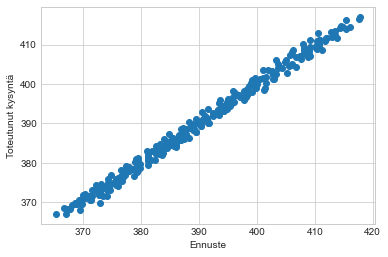

In [11]:
# Ennusteiden ja toteutuneiden kysyntöjen hajontakaavio
# Ennustemalli on sitä parempi, mitä paremmin pisteet seuraavat suoraa viivaa
# vasemmasta alakulmasta oikeaan yläkulmaan
plt.scatter(x = df['Ennuste'], y = df['Hiilidioksidi'])
plt.xlabel('Ennuste')
plt.ylabel('Toteutunut kysyntä')

In [12]:
malli.summary()

Dep. Variable:,endog,No. Observations:,252
Model:,ExponentialSmoothing,SSE,374.584
Optimized:,True,AIC,115.889
Trend:,Additive,BIC,144.125
Seasonal:,Multiplicative,AICC,116.802
Seasonal Periods:,4,Date:,"Fri, 15 Jan 2021"
Box-Cox:,False,Time:,15:49:29
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8947368,alpha,True
smoothing_slope,0.8421053,beta,True


In [13]:
#Ennusteiden laskeminen
#Ennustettavien ajankohtien aikaleimojen määrittämiseksi:
#Ensimmäisen ennustettavan ajankohdan aikaleiman täytyy olla aikasarjan viimeisintä aikaleimaa seuraava aikaleima.
#Ennustettavien ajankohtien lukumäärän voin määrittää periods-parametrilla.
#Ennustettavien ajankohtien frekvenssin on oltava sama kuin mallia sovitettaessa käytetty freq-parametrin arvo.
#Lisätietoa freq-parametrin mahdollisista arvoista https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
#Tarkistan viimeisen aikaleiman
df.tail()

,Hiilidioksidi,Ennuste,Ennustevirhe
Kuukausi,,,
2020-07-01,414.38,416.063089,-1.683089
2020-08-01,412.55,413.409623,-0.859623
2020-09-01,411.29,410.783125,0.506875
2020-10-01,411.28,409.186721,2.093279
2020-11-01,412.89,410.612142,2.277858


In [15]:
# Ennustettavien ajankohtien aikaleimat (alkupäivänä aikasarjan viimeistä aikaleimaa seuraava aikaleima)
index = pd.date_range('2020-12-01', periods = 12, freq = 'MS')

# Ennusteet 12 kuukaudelle
ennusteet = malli.forecast(12)

# Ennusteet dataframeen
df_ennuste = pd.DataFrame(data = ennusteet, index = index, 
                          columns = ['Ennuste'])
df_ennuste

,Ennuste
2020-12-01,414.616418
2021-01-01,416.584641
2021-02-01,417.995903
2021-03-01,419.034360
2021-04-01,421.006257
2021-05-01,422.980172
2021-06-01,424.388565
2021-07-01,425.418495
2021-08-01,427.396096
2021-09-01,429.375704


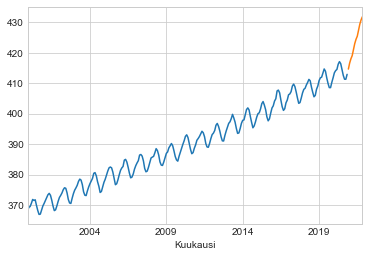

In [16]:
# Viivakaavio havainnoista
df['Hiilidioksidi'].plot()

# Ennusteet kaavioon
df_ennuste['Ennuste'].plot()

In [17]:
# Dataframe, jossa alkuperäinen aikasarja ja lasketut ennusteet
df1 = pd.concat([df, df_ennuste])
df1

,Hiilidioksidi,Ennuste,Ennustevirhe
1999-12-01,368.04,369.460535,-1.420535
2000-01-01,369.25,367.981062,1.268938
2000-02-01,369.50,368.924935,0.575065
2000-03-01,370.56,371.179813,-0.619813
2000-04-01,371.82,369.902802,1.917198
...,...,...,...
2021-07-01,NaN,425.418495,NaN
2021-08-01,NaN,427.396096,NaN
2021-09-01,NaN,429.375704,NaN
2021-10-01,NaN,430.781227,NaN
